## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [2]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib qt

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('../camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        cv2.imshow('img',img)
        cv2.waitKey(500)

cv2.destroyAllWindows()

## Calculate distortion coefficients, and test undistortion on an image

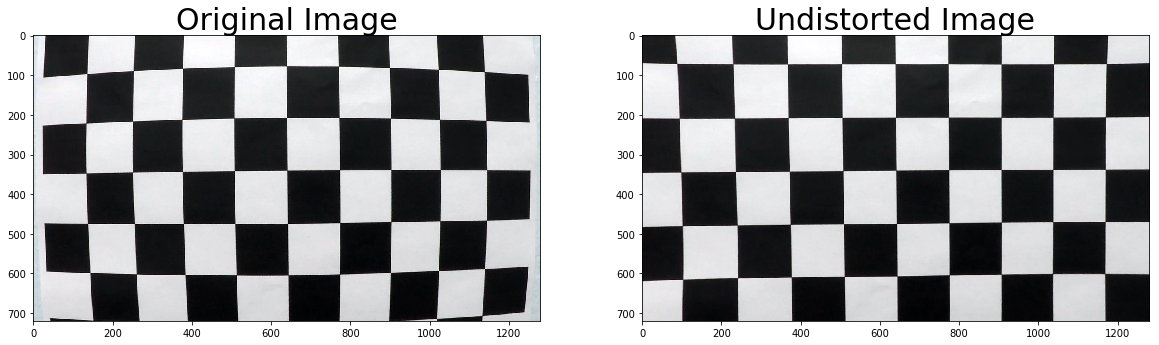

In [49]:
import pickle
%matplotlib inline

# Test undistortion on an image
img = cv2.imread('../camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)


dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('../output_images/calibration1_undist.jpg',dst)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "./dist_pickle.p", "wb" ) )
#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

## Pipeline

### 1.Use the camera calibration result we got to undistort image

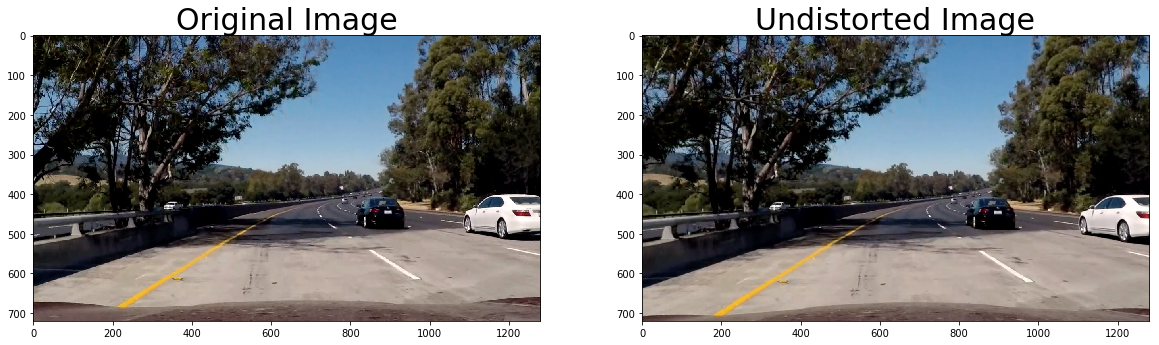

In [50]:
import pickle
 
    
# load the camera calibration result
with open("./dist_pickle.p", mode='rb') as f:
    dist_pickle = pickle.load(f)

mtx, dist = dist_pickle["mtx"], dist_pickle["dist"]

def undist(img):
    return cv2.undistort(img, mtx, dist, None, mtx)
    
# read a test image
img = cv2.imread('../test_images/test5.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

img_size = (img.shape[1], img.shape[0])

# undistort the image
undist_image = undist(img)


cv2.imwrite('../output_images/test5_undist.jpg',cv2.cvtColor(undist_image, cv2.COLOR_RGB2BGR))

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undist_image)
ax2.set_title('Undistorted Image', fontsize=30)

### 2. Create a thresholded binary image

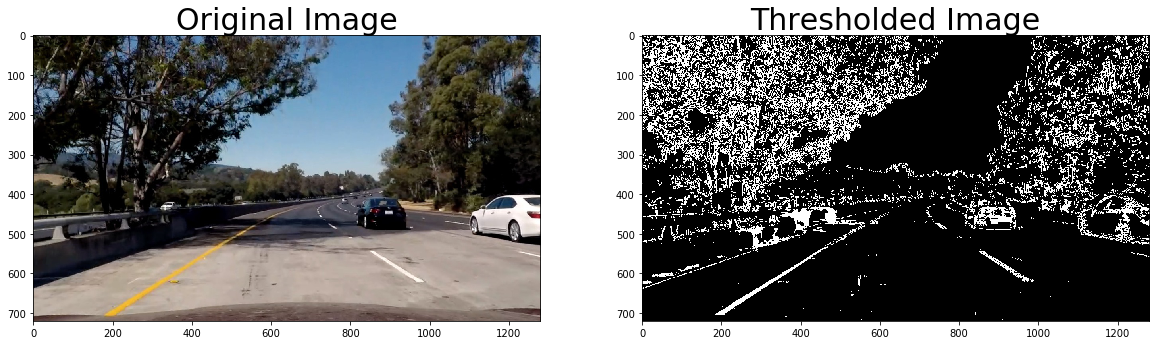

In [51]:
def threshold(img, s_thresh=(170, 255), sx_thresh=(20, 100), mag_thresh=(0, 200)):
    
    img = np.copy(img)
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]
    
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # gradient magnitude
    gradmag = np.sqrt(sobelx**2)
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    grad_binary = np.zeros_like(gradmag)
    grad_binary[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[((s_binary == 1) | (sxbinary == 1)) & (grad_binary == 1)] = 1
    
    return combined_binary


# read a test image
img = cv2.imread('../output_images/test5_undist.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_size = (img.shape[1], img.shape[0])

# undistort the image
threshold_img = threshold(img)
#cv2.imwrite('../output_images/test5_thresholded.jpg', cv2.cvtColor(threshold_img, cv2.COLOR_BGR2GRAY))
plt.imsave('../output_images/test5_thresholded.jpg', threshold_img, cmap=plt.cm.gray)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(threshold_img, cmap='gray')
ax2.set_title('Thresholded Image', fontsize=30)

### 3. Perspective transform

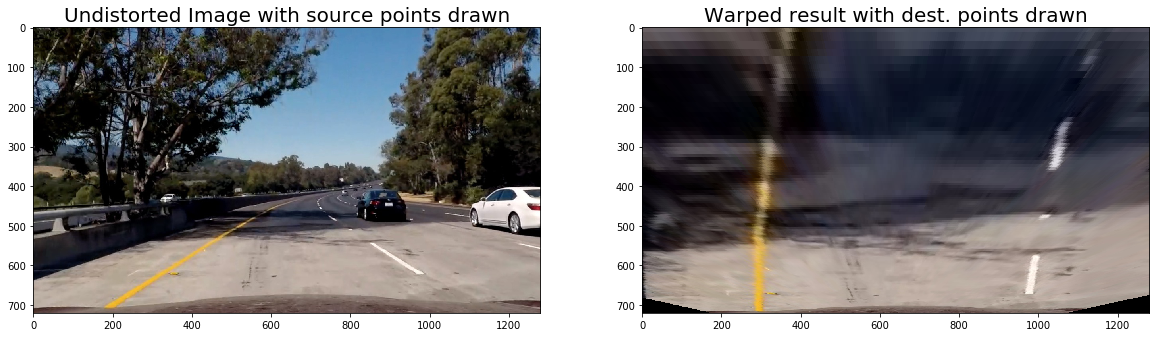

In [52]:
# read a test image
img = cv2.imread('../output_images/test5_undist.jpg')
#img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_size = (img.shape[1], img.shape[0])

# hardcode the source and destination points
src_points = np.float32(
    [[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
    [((img_size[0] / 6) - 10), img_size[1]],
    [(img_size[0] * 5 / 6) + 60, img_size[1]],
    [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])
dst_points = np.float32(
    [[(img_size[0] / 4), 0],
    [(img_size[0] / 4), img_size[1]],
    [(img_size[0] * 3 / 4), img_size[1]],
    [(img_size[0] * 3 / 4), 0]])


M = cv2.getPerspectiveTransform(src_points, dst_points)

def perspective(img):
    # Compute and apply perpective transform
    img_size = (img.shape[1], img.shape[0])
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_NEAREST)  # keep same size as input image

    return warped


# read a test image
img = cv2.imread('../output_images/test5_undist.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# wrap the image
perspective_img = perspective(img)

# output the image
cv2.imwrite('../output_images/test5_wraped.jpg',cv2.cvtColor(perspective_img, cv2.COLOR_BGR2RGB))

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Undistorted Image with source points drawn', fontsize=20)
ax2.imshow(perspective_img)
ax2.set_title('Warped result with dest. points drawn', fontsize=20)

### 4. Find the lane line

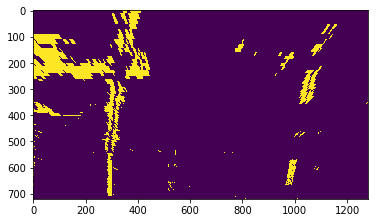

(720, 0)

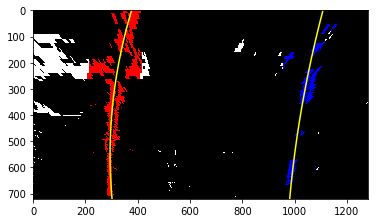

In [53]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def get_lane_lines(binary_warped):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    return leftx, lefty, rightx, righty 


# read a test image
img = cv2.imread('../test_images/test5.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# threshold
threshold_img = threshold(img)

perspective_img = perspective(threshold_img)

#print(binary_warped.shape)

plt.imshow(perspective_img)
plt.show()

leftx, lefty, rightx, righty = get_lane_lines(perspective_img)

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

# Generate x and y values for plotting
ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img = np.dstack((perspective_img, perspective_img, perspective_img))*255
out_img[lefty, leftx] = [255, 0, 0]
out_img[righty, rightx] = [0, 0, 255]
plt.imsave('../output_images/test5_lane_line.jpg', out_img)
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)



### 5. Calculate the radius of curvature 

In [54]:
y_eval = np.max(ploty)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
print(left_curverad, right_curverad)

# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)

# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')

1876.65360376 4208.22919204
609.069752912 m 1365.81771332 m


### 6. Provide an example image of your result plotted back down onto the road such that the lane area is identified clearly

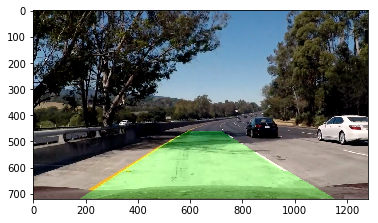

In [55]:
Minv = cv2.getPerspectiveTransform(dst_points, src_points)

def draw_lane_line(img, left_fitx, right_fitx, ploty):
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(img[:,:,1]).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    
    # Combine the result with the original image
    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)

    return result

img = cv2.imread('../test_images/test5.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

ploty = np.linspace(0, img.shape[0]-1, img.shape[0])

leftx, lefty, rightx, righty = get_lane_lines(perspective(threshold(img)))

left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]


final_img = draw_lane_line(img, left_fitx, right_fitx, ploty)

cv2.imwrite('../output_images/test5_final.jpg',cv2.cvtColor(final_img, cv2.COLOR_BGR2RGB))

plt.imshow(final_img)

### Pipeline

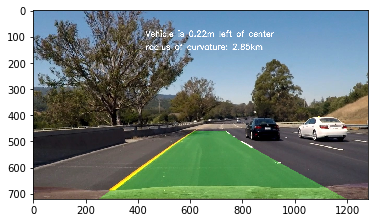

In [56]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from collections import deque

class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = deque([],maxlen=5) 
        
        self.recent_fitted = deque([],maxlen=5)
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        
        self.yvals = None
        
        # recent fit line base pos
        self.recent_line_base_pos = None
        
    def set_diffs(self):
        if len(self.recent_xfitted) > 0 and self.best_fit is not None:
            self.diffs = self.current_fit - self.best_fit
        else:
            self.diffs = np.array([0,0,0], dtype='float')    
            
    def set_line_pos_pos(self):
        y_eval = np.max(self.yvals)
        line_pos = self.current_fit[0]*y_eval**2 + self.current_fit[1]*y_eval + self.current_fit[2]
        center_pos = 640
        self.line_base_pos =abs((line_pos - center_pos)*3.7/700.0) # 3.7/700 meters per pixel in x dimension      
    
    def sanity_check(self):
        flag = True
        
        if(self.recent_line_base_pos):
            if(abs(self.line_base_pos - self.recent_line_base_pos)/self.recent_line_base_pos > 0.3): # change over 30%
                print('lane width change too much')
                flag  = False 

#         if (abs(self.line_base_pos) > 3): # over 6
#             print(self.line_base_pos)
#             print(recent_line_base_pos)
#             print('lane width too narrow or wide')
#             flag  = False

        # TODO what scale of change is unexpected change?
        if(len(self.recent_xfitted) > 0 and self.best_fit!=None and self.diffs!=None):
            fit_delta = self.diffs / self.best_fit
            if not (abs(fit_delta) < np.array([0.8,0.8,0.15])).all():
                print('fit change too much [%]', fit_delta)
                flag=False

        return flag        


    def add_line(self):
        current_fit_xvals = self.current_fit[0]*self.yvals**2 + self.current_fit[1]*self.yvals + self.current_fit[2]
        self.recent_xfitted.appendleft(current_fit_xvals)
        
        self.recent_fitted.appendleft(self.current_fit)
        
    def set_bestx(self):
        fits = self.recent_xfitted
        if len(fits)>0:
            avg=0
            for fit in fits:
                avg +=np.array(fit)
            avg = avg / len(fits)
            self.bestx = avg
            
    def set_bestfit(self):
        recent_fitted = self.recent_fitted
        if len(recent_fitted)>0:
            avg=0
            for fit in recent_fitted:
                avg +=np.array(fit)
            avg = avg / len(recent_fitted)
            self.best_fit = avg
    
    def set_radius_of_curvature(self):
        y_eval = np.max(self.yvals)
        if self.best_fit is not None:
            self.radius_of_curvature = ((1 + (2*self.best_fit[0]*y_eval + self.best_fit[1])**2)**1.5) / np.absolute(2*self.best_fit[0])
    
    def remove_old_line(self):
        if(len(self.recent_fitted) > 0):
            self.recent_xfitted.pop()
            self.recent_fitted.pop()
        
    def add_candidate_line(self, lanex, laney, yvals):
        self.allx = lanex
        self.ally = laney
        self.yvals = yvals
        self.current_fit = np.polyfit(laney, lanex, 2)
        self.set_diffs()
        self.set_line_pos_pos()    
        
        if self.sanity_check():
            self.detected = True
            self.add_line()
            self.set_bestx()
            self.set_bestfit() 
            self.set_radius_of_curvature()
            self.recent_line_base_pos = self.line_base_pos     
        else:
            self.detected=False
            self.remove_old_line()
            self.set_bestfit()
            self.set_bestx()            
        
            
def pipeline(img):
    global left_line
    global right_line
    undist_img = undist(img)
    threshold_img = threshold(undist_img)
    perspective_img = perspective(threshold_img)
    leftx, lefty, rightx, righty = get_lane_lines(perspective_img)
    
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0])

    left_line.add_candidate_line(leftx, lefty, ploty)
    right_line.add_candidate_line(rightx, righty, ploty)
    
    left_fitx = left_line.bestx
    right_fitx = right_line.bestx
    
    
    # we only need y from 0..720 and the response x to draw a line
    result = draw_lane_line(img, left_fitx, right_fitx, ploty)
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    
    distance_of_center = round((left_line.line_base_pos - right_line.line_base_pos)/2, 2)
    if(distance_of_center < 0):
        str1 = str('Vehicle is '+str(abs(distance_of_center))+'m left of center')
    else:
        str1 = str('Vehicle is '+str(abs(distance_of_center))+'m right of center')
    cv2.putText(result,str1,(430,100), font, 1,(255,255,255),2,cv2.LINE_AA)
    
    if left_line.radius_of_curvature and right_line.radius_of_curvature:
        curvature = 0.5*(round(right_line.radius_of_curvature/1000,1) + round(left_line.radius_of_curvature/1000,1))
        str2 = str('radius of curvature: '+str(curvature)+'km')
        cv2.putText(result,str2,(430,150), font, 1,(255,255,255),2,cv2.LINE_AA)
    
#     str3 = str(round(right_line.current_fit[0],2)) + " "+str(round(right_line.current_fit[1],2)) + " "+str(round(right_line.current_fit[2],2))
#     cv2.putText(result,str3,(430,200), font, 1,(255,255,255),2,cv2.LINE_AA)
    
#     str4 = str(round(right_line.best_fit[0],2)) + " "+str(round(right_line.best_fit[1],2)) + " "+str(round(right_line.best_fit[2],2))
#     cv2.putText(result,str4,(430,250), font, 1,(255,255,255),2,cv2.LINE_AA)
    
    return result
    
left_line = Line()
right_line = Line()

img = cv2.imread('../test_images/test6.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

result = pipeline(img)

plt.imshow(result)


### 8. Apply the pipeline on the video

In [48]:
left_line = Line()
right_line = Line()

output_video = '../project_video_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip("../project_video.mp4").subclip(20,30)
clip1 = VideoFileClip("../project_video.mp4")
white_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output_video, audio=False)

[MoviePy] >>>> Building video ../project_video_output.mp4
[MoviePy] Writing video ../project_video_output.mp4


  1%|          | 9/1261 [00:01<02:48,  7.43it/s]

fit change too much [%] [-1.27848453 -0.60857053  0.01686922]
fit change too much [%] [-1.50995161 -0.71348989  0.02459446]


  1%|          | 11/1261 [00:01<02:50,  7.32it/s]

fit change too much [%] [-1.39537339 -0.65433037  0.02384964]


  1%|▏         | 16/1261 [00:02<02:52,  7.23it/s]

fit change too much [%] [ 1.34552621  0.64339434 -0.03873327]
fit change too much [%] [ 2.01884277  0.96918772 -0.06238688]


  1%|▏         | 18/1261 [00:02<02:49,  7.32it/s]

fit change too much [%] [ 1.29969386  0.75483936 -0.06033761]
fit change too much [%] [ 0.92266997  0.61306838 -0.05880029]


  2%|▏         | 20/1261 [00:02<02:49,  7.33it/s]

fit change too much [%] [ 1.55462379  0.61148923 -0.04711273]


  2%|▏         | 23/1261 [00:03<02:47,  7.37it/s]

fit change too much [%] [-1.34119179 -0.40483414  0.02380076]
fit change too much [%] [-1.31254886 -0.44374231  0.03025562]


  2%|▏         | 31/1261 [00:04<02:47,  7.32it/s]

fit change too much [%] [ 0.87304975  0.60902144 -0.02910519]


  3%|▎         | 35/1261 [00:04<02:46,  7.35it/s]

fit change too much [%] [-1.20933352 -0.36078542 -0.00681888]
fit change too much [%] [ -8.18578470e-01  -2.92548813e-01  -7.73727566e-04]


  3%|▎         | 40/1261 [00:05<02:48,  7.23it/s]

fit change too much [%] [ 1.01611932  0.53666538 -0.04254978]
fit change too much [%] [ 1.20947997  0.60716003 -0.043015  ]


  4%|▍         | 48/1261 [00:06<02:43,  7.42it/s]

fit change too much [%] [-0.88972687 -0.43449106  0.0314078 ]


  4%|▍         | 54/1261 [00:07<02:47,  7.20it/s]

fit change too much [%] [ 1.05924794  0.54135975 -0.03801889]
fit change too much [%] [ 0.81765739  0.51856313 -0.04673089]


  5%|▍         | 60/1261 [00:08<02:41,  7.42it/s]

fit change too much [%] [-0.91111724 -0.28889281 -0.00406433]


  5%|▌         | 65/1261 [00:08<02:43,  7.32it/s]

fit change too much [%] [ 0.89256714  0.31411237 -0.02473084]


  6%|▌         | 73/1261 [00:10<02:42,  7.29it/s]

fit change too much [%] [ 0.84664103  0.1956639   0.00114437]


  7%|▋         | 85/1261 [00:11<02:36,  7.49it/s]

fit change too much [%] [-0.87730359 -0.51357636  0.03501785]
fit change too much [%] [-1.090977   -0.62581938  0.04054415]


  7%|▋         | 87/1261 [00:11<02:36,  7.48it/s]

fit change too much [%] [-1.13211554 -0.64201387  0.04108349]


  7%|▋         | 91/1261 [00:12<02:33,  7.60it/s]

fit change too much [%] [ 0.82144089  0.55143833 -0.04753515]
fit change too much [%] [ 0.85236446  0.47669129 -0.03332529]


  9%|▉         | 111/1261 [00:15<02:42,  7.07it/s]

fit change too much [%] [-1.01851845 -0.55087393  0.02353357]


  9%|▉         | 116/1261 [00:15<02:40,  7.14it/s]

fit change too much [%] [ 0.9474108   0.61598524 -0.03035987]
fit change too much [%] [ 0.89638509  0.7095032  -0.0436665 ]


 11%|█▏        | 142/1261 [00:19<02:31,  7.36it/s]

fit change too much [%] [  9.54458108e-01   2.83820380e-01   6.04389658e-04]
fit change too much [%] [ 1.79417434  0.58164432 -0.01386301]


 11%|█▏        | 144/1261 [00:19<02:34,  7.21it/s]

fit change too much [%] [ 1.37148015  0.4877482  -0.02294184]
fit change too much [%] [ 1.16775143  0.42565407 -0.02419353]


 12%|█▏        | 149/1261 [00:20<02:27,  7.52it/s]

fit change too much [%] [ 1.68529276  0.60499972 -0.03388796]
fit change too much [%] [ 0.95182864  0.36066419 -0.02319595]


 12%|█▏        | 151/1261 [00:20<02:33,  7.21it/s]

fit change too much [%] [ 1.85258035  0.40306571 -0.01415355]
fit change too much [%] [ 5.5903376   1.03845991 -0.02965223]


 13%|█▎        | 160/1261 [00:21<02:27,  7.48it/s]

fit change too much [%] [-1.18615062 -0.50279165  0.01032087]


 13%|█▎        | 166/1261 [00:22<02:26,  7.50it/s]

fit change too much [%] [ 1.69340445  0.6941802  -0.04225706]
fit change too much [%] [ 1.52374706  0.63772407 -0.03994607]


 13%|█▎        | 168/1261 [00:22<02:26,  7.47it/s]

fit change too much [%] [ 1.69735018  0.69487286 -0.04886363]
fit change too much [%] [ 2.69077197  0.72137679 -0.03550607]


 13%|█▎        | 170/1261 [00:23<02:29,  7.31it/s]

fit change too much [%] [ 2.44793936  0.58572322 -0.02276928]


 14%|█▍        | 174/1261 [00:23<02:24,  7.52it/s]

fit change too much [%] [ 1.94921216  0.8223351  -0.03484164]
fit change too much [%] [ 1.62448104  0.81592914 -0.05147699]


 14%|█▍        | 176/1261 [00:24<02:28,  7.29it/s]

fit change too much [%] [ 2.83119967  1.30736351 -0.07396761]


 16%|█▌        | 198/1261 [00:26<02:21,  7.54it/s]

fit change too much [%] [-0.80318618 -0.49735611  0.09031995]
fit change too much [%] [-0.92668855 -0.64550553  0.12645106]


 16%|█▌        | 200/1261 [00:27<02:23,  7.41it/s]

fit change too much [%] [-0.91135698 -0.70374625  0.14555069]


 18%|█▊        | 222/1261 [00:30<02:29,  6.93it/s]

fit change too much [%] [-1.18707124 -0.49503134  0.02756538]
fit change too much [%] [-1.16324504 -0.49277009  0.02949755]


 18%|█▊        | 227/1261 [00:31<02:23,  7.20it/s]

fit change too much [%] [ 1.47493482  0.50548532 -0.03360073]
fit change too much [%] [ 1.85902427  0.59395435 -0.03525051]


 18%|█▊        | 229/1261 [00:31<02:25,  7.11it/s]

fit change too much [%] [ 1.50201971  0.49106809 -0.02616284]
fit change too much [%] [ 1.56945453  0.38602236 -0.01649462]


 18%|█▊        | 231/1261 [00:31<02:24,  7.11it/s]

fit change too much [%] [ 2.40215115  0.46085188 -0.01297889]


 19%|█▊        | 236/1261 [00:32<02:23,  7.13it/s]

fit change too much [%] [ 0.96024225  0.33407578 -0.01364206]


 19%|█▉        | 239/1261 [00:32<02:20,  7.28it/s]

fit change too much [%] [ 1.48958104  0.72880296 -0.05390121]
fit change too much [%] [ 1.53152695  0.76110528 -0.05959282]


 19%|█▉        | 241/1261 [00:32<02:21,  7.20it/s]

fit change too much [%] [ 0.84330818  0.51231428 -0.04649401]


 21%|██▏       | 271/1261 [00:37<02:17,  7.19it/s]

fit change too much [%] [-0.95506353 -0.53285554  0.03249532]


 24%|██▍       | 306/1261 [00:41<02:11,  7.28it/s]

fit change too much [%] [-1.83782046 -1.06040372  0.02807574]
fit change too much [%] [-1.76780151 -0.92422056  0.01288226]


 24%|██▍       | 308/1261 [00:42<02:14,  7.11it/s]

fit change too much [%] [-1.39032292 -0.82732712  0.01989093]
fit change too much [%] [-1.44614921 -0.7051015   0.00585313]


 25%|██▍       | 310/1261 [00:42<02:20,  6.77it/s]

fit change too much [%] [-1.69159113 -0.80170377  0.01204204]


 25%|██▍       | 312/1261 [00:42<02:14,  7.04it/s]

fit change too much [%] [ 2.19710726  0.67711637 -0.013462  ]


 25%|██▍       | 314/1261 [00:43<02:13,  7.11it/s]

fit change too much [%] [-0.87652425 -0.28557795 -0.00518319]
fit change too much [%] [-0.81193624 -0.44301315  0.0599906 ]


 25%|██▌       | 316/1261 [00:43<02:27,  6.41it/s]

fit change too much [%] [-1.00502688 -0.50442661  0.05753589]
fit change too much [%] [-1.20345328 -0.46459261  0.03862965]
fit change too much [%] [ 0.72490455 -0.87001718  0.01598377]


 25%|██▌       | 318/1261 [00:43<02:20,  6.69it/s]

fit change too much [%] [-0.90878834 -0.30179054  0.02099915]
fit change too much [%] [-5.169265   -0.36938237  0.02035293]
fit change too much [%] [-1.37115901 -0.56540191  0.03978455]


 25%|██▌       | 321/1261 [00:44<02:13,  7.06it/s]

fit change too much [%] [ 0.95544299 -0.45125492  0.02368325]
fit change too much [%] [ 0.86039601  1.02755568 -0.01124236]
fit change too much [%] [ 1.3091821   1.75183989 -0.01133116]


 26%|██▌       | 323/1261 [00:44<02:09,  7.26it/s]

fit change too much [%] [ 3.36591218 -0.88465978  0.00913104]


 26%|██▌       | 325/1261 [00:44<02:08,  7.27it/s]

fit change too much [%] [ -3.14539065e-03   4.21361537e+00  -1.93542024e-02]


 26%|██▌       | 327/1261 [00:44<02:08,  7.25it/s]

fit change too much [%] [  3.63768876e-01   2.05588909e+01   1.02229899e-02]


 26%|██▌       | 329/1261 [00:45<02:05,  7.41it/s]

fit change too much [%] [  6.02122482e-02  -8.27554466e-01   4.90904839e-04]
fit change too much [%] [-0.69044426 -0.92222853  0.01664103]
fit change too much [%] [-1.54758538 -1.99709563  0.03230842]


 26%|██▌       | 331/1261 [00:45<02:07,  7.32it/s]

fit change too much [%] [-0.71543414 -1.02537481  0.01545235]
fit change too much [%] [-0.94273873 -1.21310725  0.0089683 ]


 26%|██▋       | 333/1261 [00:45<02:06,  7.33it/s]

fit change too much [%] [-1.25033521 -0.58722257  0.0466124 ]
fit change too much [%] [ 0.2724976   1.77647466 -0.01793661]
fit change too much [%] [-1.71843446 -0.70879372  0.0488834 ]


 27%|██▋       | 335/1261 [00:45<02:08,  7.19it/s]

fit change too much [%] [-1.77693496 -0.56239793  0.03725687]


 27%|██▋       | 337/1261 [00:46<02:06,  7.29it/s]

fit change too much [%] [ 0.1497875   3.01792758 -0.03446366]


 27%|██▋       | 339/1261 [00:46<02:05,  7.37it/s]

fit change too much [%] [  9.14579322e+00  -1.89689485e-01  -1.45136652e-03]
fit change too much [%] [-0.73322716 -1.13975322  0.02550049]
fit change too much [%] [-1.00602742 -1.51736399  0.02521475]


 27%|██▋       | 341/1261 [00:46<02:04,  7.37it/s]

fit change too much [%] [  0.55624727 -11.54737803   0.02606631]
fit change too much [%] [-1.33646076 -1.82353632  0.01432193]
fit change too much [%] [-1.83883241 -2.79197547  0.01192746]


 27%|██▋       | 343/1261 [00:47<02:08,  7.16it/s]

fit change too much [%] [ 0.12270748  0.88631608  0.03235161]
fit change too much [%] [-1.46147978 -2.22274275 -0.00624381]


 27%|██▋       | 346/1261 [00:47<02:05,  7.30it/s]

fit change too much [%] [-0.91459037 -0.31520576  0.00359641]
fit change too much [%] [-1.42292595 -0.5320518   0.00511915]


 28%|██▊       | 349/1261 [00:47<02:04,  7.35it/s]

fit change too much [%] [-0.3536031  -0.88935538 -0.02508889]
fit change too much [%] [-0.27940628 -0.86636911  0.01290556]
fit change too much [%] [-0.5642897  -0.8715803  -0.01001514]


 28%|██▊       | 351/1261 [00:48<02:06,  7.22it/s]

fit change too much [%] [-0.55050936 -1.19574301 -0.02053785]
fit change too much [%] [-0.34871145 -3.29193717  0.01219179]
fit change too much [%] [-0.97008881 -1.88525652 -0.0155394 ]


 28%|██▊       | 353/1261 [00:48<02:05,  7.24it/s]

fit change too much [%] [-1.50474834 -3.75359383 -0.02350582]
fit change too much [%] [-1.34674368  1.15745861  0.00484292]


 28%|██▊       | 355/1261 [00:48<02:04,  7.29it/s]

fit change too much [%] [  2.18699882e+00   3.43030561e-01  -1.41739427e-03]


 28%|██▊       | 357/1261 [00:48<02:02,  7.40it/s]

fit change too much [%] [-1.59490915 -0.4640455  -0.00570595]


 29%|██▊       | 360/1261 [00:49<02:00,  7.46it/s]

fit change too much [%] [ 3.28570328 -3.62031436 -0.02224751]
fit change too much [%] [-0.96863194 -0.60949457  0.02159657]
fit change too much [%] [ 2.03325957 -2.16514482 -0.01315693]


 29%|██▊       | 362/1261 [00:49<02:01,  7.39it/s]

fit change too much [%] [-1.00190169 -0.54761043  0.0112701 ]
fit change too much [%] [-2.26342384 -1.39893467  0.03874649]
fit change too much [%] [ -4.02170378e-01  -1.20943146e+00  -8.12153353e-04]


 29%|██▉       | 364/1261 [00:49<02:00,  7.43it/s]

fit change too much [%] [-3.12877397 -1.78812813  0.04423031]
fit change too much [%] [-6.35736502 -3.17897279  0.06851011]


 29%|██▉       | 367/1261 [00:50<01:57,  7.58it/s]

fit change too much [%] [ 3.87703376 -0.79890696 -0.00549117]
fit change too much [%] [-5.81791448  0.990042    0.00958854]


 29%|██▉       | 369/1261 [00:50<01:56,  7.63it/s]

fit change too much [%] [-12.00603869   2.06408608   0.015874  ]


 29%|██▉       | 371/1261 [00:50<01:57,  7.55it/s]

fit change too much [%] [ 0.12405486 -1.01159827  0.00699328]


 30%|██▉       | 373/1261 [00:51<01:59,  7.42it/s]

fit change too much [%] [-0.22435482 -0.97405641  0.00787247]


 30%|██▉       | 375/1261 [00:51<02:00,  7.36it/s]

fit change too much [%] [ -1.34780372e+00   4.09719891e+00   1.85382079e-03]


 30%|███       | 379/1261 [00:51<02:00,  7.33it/s]

fit change too much [%] [-1.15395521 -0.56916373  0.00700953]
fit change too much [%] [-1.52483515 -0.80073564 -0.01097925]


 30%|███       | 381/1261 [00:52<02:01,  7.23it/s]

fit change too much [%] [-2.08338306 -1.09297394 -0.03052359]
fit change too much [%] [-2.90889501 -1.26537129 -0.04589971]
fit change too much [%] [-1.39835246 -0.16447484  0.01202069]


 30%|███       | 383/1261 [00:52<02:01,  7.24it/s]

fit change too much [%] [-2.75165005 -1.15068609 -0.04383959]
fit change too much [%] [-3.52919036 -0.8862003   0.00678955]
fit change too much [%] [-5.56383392 -1.54713597 -0.00617941]


 31%|███       | 385/1261 [00:52<02:02,  7.14it/s]

fit change too much [%] [-3.92739594 -1.21482061 -0.00886765]
fit change too much [%] [-2.58920821 -0.76574658 -0.00752986]


 31%|███       | 388/1261 [00:53<02:00,  7.26it/s]

fit change too much [%] [-0.97576779  0.01213994 -0.02807725]
fit change too much [%] [-1.08973562 -0.2377987  -0.02198275]
fit change too much [%] [-2.42329749  0.73250392  0.00371877]


 31%|███       | 390/1261 [00:53<01:59,  7.30it/s]

fit change too much [%] [-0.0390784   4.15619841 -0.0410333 ]
fit change too much [%] [-4.68972272  1.11510044  0.00559545]
fit change too much [%] [-0.63366012  2.61296219 -0.04904613]


 31%|███       | 393/1261 [00:53<02:00,  7.22it/s]

fit change too much [%] [ 1.10344507  0.32551084 -0.01615666]
fit change too much [%] [-0.95980589 -0.5489763  -0.0172971 ]


 32%|███▏      | 398/1261 [00:54<01:57,  7.31it/s]

fit change too much [%] [-1.77786668 -0.74078931 -0.01229511]
fit change too much [%] [-1.97979207 -0.76790438 -0.01377517]


 32%|███▏      | 400/1261 [00:54<01:58,  7.26it/s]

fit change too much [%] [-1.64494892 -0.47351296 -0.00368026]


 32%|███▏      | 402/1261 [00:55<01:54,  7.52it/s]

fit change too much [%] [ 1.41508064  0.36251008  0.00740542]
fit change too much [%] [ 7.88605801  1.03690484  0.01280981]


 32%|███▏      | 404/1261 [00:55<01:56,  7.37it/s]

fit change too much [%] [  1.91384560e+01   1.68943291e+00   1.23165874e-02]


 32%|███▏      | 406/1261 [00:55<01:53,  7.53it/s]

fit change too much [%] [-0.84184276 -0.26056239  0.00680171]
fit change too much [%] [-1.08938621 -0.71658207 -0.02249908]
fit change too much [%] [-1.01271534 -0.23051301 -0.00545644]


 32%|███▏      | 408/1261 [00:55<01:54,  7.48it/s]

fit change too much [%] [-1.86045752 -0.36852017 -0.00790904]
fit change too much [%] [  1.98979433e+02   4.98114114e-01   6.02329350e-03]
fit change too much [%] [-2.42177082 -0.39931876 -0.00668819]


 33%|███▎      | 410/1261 [00:56<01:53,  7.53it/s]

fit change too much [%] [ -3.61085269e+00  -5.25158051e-01  -1.57313928e-03]
fit change too much [%] [-1.42446824 -0.45913185 -0.00766994]


 33%|███▎      | 412/1261 [00:56<01:53,  7.46it/s]

fit change too much [%] [ -1.87867609e-01  -2.71860120e+00   1.85216779e-03]


 33%|███▎      | 414/1261 [00:56<01:55,  7.36it/s]

fit change too much [%] [-1.56295007  0.49124491  0.00213856]
fit change too much [%] [-1.07121986  0.38376787 -0.0043808 ]


 33%|███▎      | 416/1261 [00:56<01:56,  7.27it/s]

fit change too much [%] [-1.75989914  0.10028413  0.02507413]
fit change too much [%] [-2.9638323   0.37695238 -0.00573949]


 33%|███▎      | 418/1261 [00:57<01:55,  7.28it/s]

fit change too much [%] [ -5.28405646e+00   3.60852051e-01   3.33369863e-03]
fit change too much [%] [-1.22342769 -0.77702129 -0.0176887 ]
fit change too much [%] [-0.98872631 -0.61042212 -0.01204774]


 33%|███▎      | 421/1261 [00:57<01:54,  7.35it/s]

fit change too much [%] [-1.03338424 -0.62154559 -0.01775921]
fit change too much [%] [-0.87024668 -0.41259457  0.02100515]
fit change too much [%] [-1.79478297 -0.87040618 -0.02021744]


 34%|███▎      | 424/1261 [00:58<01:54,  7.32it/s]

fit change too much [%] [-1.10903616  0.90943059  0.00953319]


 34%|███▍      | 426/1261 [00:58<01:54,  7.28it/s]

fit change too much [%] [  2.53997516e+00   4.48503275e-01   2.36223118e-03]


 34%|███▍      | 429/1261 [00:58<01:52,  7.40it/s]

fit change too much [%] [-1.06413564 -0.60456619 -0.01326345]
fit change too much [%] [-1.19013259 -0.7180602  -0.01909346]


 34%|███▍      | 432/1261 [00:59<01:49,  7.60it/s]

fit change too much [%] [ 0.97259019  0.34420557  0.01037097]


 34%|███▍      | 434/1261 [00:59<01:50,  7.51it/s]

fit change too much [%] [-0.80457331  0.03984247 -0.0433343 ]
fit change too much [%] [-1.7906421  -0.19847927 -0.02431746]
fit change too much [%] [-3.45387387 -0.94315248 -0.01794581]


 35%|███▍      | 436/1261 [00:59<01:51,  7.37it/s]

fit change too much [%] [-2.21053527 -0.29803825 -0.01442118]
fit change too much [%] [-3.18606185 -0.85140049 -0.02237803]
fit change too much [%] [-2.15988485 -0.41756904  0.0129435 ]


 35%|███▍      | 438/1261 [00:59<01:51,  7.40it/s]

fit change too much [%] [-4.78932077 -0.8616517   0.05760972]
fit change too much [%] [ -5.00068735e+00   1.05633120e+00  -4.04257325e-03]


 35%|███▍      | 440/1261 [01:00<01:52,  7.31it/s]

fit change too much [%] [ 0.42828295 -1.5129281   0.04735423]
fit change too much [%] [-1.16699572 -0.66976032 -0.01681532]


 35%|███▌      | 443/1261 [01:00<01:50,  7.40it/s]

fit change too much [%] [-2.6242729   0.55572192  0.00676281]


 35%|███▌      | 445/1261 [01:00<01:50,  7.39it/s]

fit change too much [%] [  1.37090989e+01  -1.46174930e+00  -8.48558978e-03]
fit change too much [%] [ 10.50599005  -1.09696833  -0.01339501]


 36%|███▌      | 448/1261 [01:01<01:54,  7.12it/s]

fit change too much [%] [ 0.01518596  1.26029797  0.03317637]
fit change too much [%] [ -4.67912911e-01  -6.83676802e+00  -5.27072026e-03]
fit change too much [%] [-0.18328641  0.87974108  0.03488265]


 36%|███▌      | 450/1261 [01:01<01:52,  7.20it/s]

fit change too much [%] [-0.11531013  1.99641097  0.05961607]
fit change too much [%] [ -3.08273684e+00   1.02979321e+00  -3.30229685e-04]
fit change too much [%] [-0.18725998  1.47646999  0.0602226 ]


 36%|███▌      | 452/1261 [01:01<01:53,  7.11it/s]

fit change too much [%] [ -3.45307370e+01  -1.38642926e+00  -1.25880774e-02]


 36%|███▌      | 454/1261 [01:02<01:51,  7.21it/s]

fit change too much [%] [-0.45769278 -4.40567315  0.00923499]


 36%|███▌      | 456/1261 [01:02<01:49,  7.36it/s]

fit change too much [%] [-1.09432712 -0.67338052  0.02586598]
fit change too much [%] [  8.34368172e-01  -4.59671172e+01  -3.05704724e-03]


 36%|███▋      | 458/1261 [01:02<01:48,  7.40it/s]

fit change too much [%] [-0.49812174 -1.04472357  0.00681888]


 36%|███▋      | 460/1261 [01:02<01:48,  7.41it/s]

fit change too much [%] [-1.29745312 -0.16746137  0.0397429 ]
fit change too much [%] [-1.55547411 -0.43919739  0.02051952]
fit change too much [%] [-2.49681314  1.35696671  0.0078343 ]


 37%|███▋      | 462/1261 [01:03<01:46,  7.51it/s]

fit change too much [%] [-2.73116105 -1.13187829  0.00342376]
fit change too much [%] [ -2.06781143e+01   2.59585570e+00   1.81016057e-02]
fit change too much [%] [-3.01609577 -1.3932103  -0.01473596]


 37%|███▋      | 464/1261 [01:03<01:46,  7.49it/s]

fit change too much [%] [-4.25605594 -2.1449998  -0.04053332]
fit change too much [%] [-1.02935875 -0.61953508 -0.01565898]


 37%|███▋      | 472/1261 [01:04<01:46,  7.42it/s]

fit change too much [%] [ 1.35925151  0.42087022  0.00703245]
fit change too much [%] [ 2.40509546  0.63682027  0.01118442]


 38%|███▊      | 474/1261 [01:04<01:47,  7.31it/s]

fit change too much [%] [ 4.97114602  1.01099109  0.01757368]
fit change too much [%] [ 7.49111078  1.20725858  0.01478465]


 38%|███▊      | 476/1261 [01:05<01:48,  7.26it/s]

fit change too much [%] [-0.8431212  -0.19295882 -0.02046223]
fit change too much [%] [ 4.62253608  0.84287104  0.01862459]
fit change too much [%] [-1.21822842 -0.38754335 -0.01250661]


 38%|███▊      | 478/1261 [01:05<01:48,  7.23it/s]

fit change too much [%] [-1.79647611 -0.3688145  -0.02904625]
fit change too much [%] [  8.45437963e+00  -2.30135536e-01   5.25858686e-03]
fit change too much [%] [-1.75602923  0.01278015 -0.04489351]


 38%|███▊      | 480/1261 [01:05<01:47,  7.29it/s]

fit change too much [%] [-4.54782704 -0.29976732 -0.05008989]
fit change too much [%] [-1.934037    0.07096323  0.00487554]


 38%|███▊      | 482/1261 [01:05<01:46,  7.28it/s]

fit change too much [%] [-2.53801128 -0.35727506 -0.0113812 ]


 38%|███▊      | 485/1261 [01:06<01:46,  7.25it/s]

fit change too much [%] [ 0.13454478 -0.83052581  0.01497191]
fit change too much [%] [-1.61641879  0.48757378  0.00340016]


 39%|███▊      | 487/1261 [01:06<01:45,  7.31it/s]

fit change too much [%] [ -3.63943426e+00   1.01291797e+00   2.16845044e-03]
fit change too much [%] [-1.04646081  0.68140464  0.03071864]
fit change too much [%] [-7.20855995  1.23085548  0.00858535]


 39%|███▉      | 489/1261 [01:06<01:46,  7.24it/s]

fit change too much [%] [-0.85179433 -0.74358563  0.06545799]
fit change too much [%] [-0.95235904 -0.9935611   0.07585028]
fit change too much [%] [ -4.15733115e+00   2.91616363e-01  -1.07400460e-03]


 39%|███▉      | 491/1261 [01:07<01:46,  7.25it/s]

fit change too much [%] [ -2.39698592e-04  -2.57298220e+00   6.91758217e-02]
fit change too much [%] [ 0.60567063 -2.62112748  0.06169252]
fit change too much [%] [-2.18047396 -0.69282827 -0.01568582]


 39%|███▉      | 494/1261 [01:07<01:44,  7.37it/s]

fit change too much [%] [ -9.48487426e-01   9.80789153e-01  -9.76280924e-04]


 39%|███▉      | 496/1261 [01:07<01:44,  7.29it/s]

fit change too much [%] [ 0.60953624 -1.56198555 -0.00257297]
fit change too much [%] [-0.24998394  1.33376988  0.00977854]
fit change too much [%] [-0.33494814  1.84759224  0.00723752]


 39%|███▉      | 498/1261 [01:08<01:44,  7.31it/s]

fit change too much [%] [-0.17471135  1.31993816 -0.00389668]
fit change too much [%] [-1.88821731  5.69495695  0.01182673]


 40%|███▉      | 501/1261 [01:08<01:43,  7.32it/s]

fit change too much [%] [-1.54346195  2.23907315 -0.04009081]
fit change too much [%] [-1.86588976  2.56567545 -0.05486509]
fit change too much [%] [-0.85271806 -0.22829199  0.00894019]


 40%|███▉      | 503/1261 [01:08<01:43,  7.33it/s]

fit change too much [%] [-0.99500028 -0.2687298   0.01261482]
fit change too much [%] [-2.1314602  -0.11757544  0.03200673]


 40%|████      | 507/1261 [01:09<01:43,  7.32it/s]

fit change too much [%] [-1.39690268 -0.45931342 -0.01079424]
fit change too much [%] [-1.95074961 -0.58916773 -0.01516903]


 40%|████      | 509/1261 [01:09<01:43,  7.25it/s]

fit change too much [%] [-1.72457703 -0.61036115 -0.02060786]
fit change too much [%] [-1.80354615 -0.57926561 -0.01716752]


 41%|████      | 514/1261 [01:10<01:44,  7.14it/s]

fit change too much [%] [-1.86916706 -0.70243664 -0.0236098 ]
fit change too much [%] [-1.50868797 -0.62718902 -0.01954501]


 41%|████      | 516/1261 [01:10<01:42,  7.27it/s]

fit change too much [%] [-0.94165861 -0.20194576  0.01665756]
fit change too much [%] [-2.12150983 -0.21686073 -0.00358177]


 41%|████      | 518/1261 [01:10<01:43,  7.19it/s]

fit change too much [%] [-2.0028506  -0.06659502 -0.02549256]
fit change too much [%] [ -1.19991667e+00  -2.69083984e-01   8.98382219e-04]
fit change too much [%] [-3.08402249 -0.41725154 -0.01207827]
fit change too much [%] [-4.39090951 -0.83194017 -0.00953174]


 41%|████      | 520/1261 [01:11<01:43,  7.16it/s]

fit change too much [%] [-3.3165892  -0.31397152 -0.01819781]
fit change too much [%] [-5.64303797 -0.87955662 -0.00781563]


 41%|████▏     | 522/1261 [01:11<01:41,  7.25it/s]

fit change too much [%] [ -3.44179099e-01  -4.15504052e+00  -9.41054022e-04]
fit change too much [%] [-0.30462986  0.98588638  0.00536129]


 42%|████▏     | 524/1261 [01:11<01:41,  7.30it/s]

fit change too much [%] [-0.87839702  1.51769529  0.0052532 ]
fit change too much [%] [  7.37429862e+00   4.93050650e-01   5.89436166e-03]


 42%|████▏     | 526/1261 [01:12<01:42,  7.19it/s]

fit change too much [%] [-1.26596426 -0.51005067 -0.01195923]
fit change too much [%] [-1.0292219   0.00396806 -0.02014552]


 42%|████▏     | 528/1261 [01:12<01:41,  7.24it/s]

fit change too much [%] [-3.58358313 -0.47121901 -0.00536032]


 42%|████▏     | 530/1261 [01:12<01:42,  7.16it/s]

fit change too much [%] [-1.24732545 -0.10448611 -0.01307456]
fit change too much [%] [-2.32773897 -0.75330916  0.05777823]
fit change too much [%] [-1.53615819  0.44040053 -0.00706096]


 42%|████▏     | 532/1261 [01:12<01:43,  7.07it/s]

fit change too much [%] [-1.53771586  0.1820646  -0.01175961]
fit change too much [%] [-4.48682421 -2.26268906  0.12736864]


 42%|████▏     | 534/1261 [01:13<01:40,  7.22it/s]

fit change too much [%] [-7.79686551 -4.96028019  0.13489832]
fit change too much [%] [ 1.65357572  1.96634981 -0.0261821 ]


 43%|████▎     | 536/1261 [01:13<01:39,  7.30it/s]

fit change too much [%] [-1.54882936 -1.59322446 -0.19310846]


 43%|████▎     | 540/1261 [01:13<01:39,  7.28it/s]

fit change too much [%] [-0.96503681 -1.21792774  0.09228631]
fit change too much [%] [-0.92699018 -1.1236752   0.06983678]


 43%|████▎     | 542/1261 [01:14<01:38,  7.31it/s]

fit change too much [%] [-1.09277199 -1.34505425  0.06277096]
fit change too much [%] [-1.27741456 -1.65992997  0.0506268 ]


 43%|████▎     | 544/1261 [01:14<01:37,  7.38it/s]

fit change too much [%] [-1.4451607  -1.85228477  0.06945142]


 43%|████▎     | 546/1261 [01:14<01:33,  7.62it/s]

fit change too much [%] [ 1.00121566  0.79680087  0.03829761]


 43%|████▎     | 548/1261 [01:15<01:33,  7.59it/s]

fit change too much [%] [-1.92210596 -1.80116728 -0.26554548]
fit change too much [%] [-1.90640623 -1.85231092 -0.30468168]


 44%|████▎     | 550/1261 [01:15<01:32,  7.66it/s]

fit change too much [%] [-2.16176768 -2.10529422 -0.33752393]
fit change too much [%] [-2.48136732 -2.50274137 -0.31915567]


 44%|████▍     | 552/1261 [01:15<01:32,  7.64it/s]

fit change too much [%] [-2.75368087 -2.65633728 -0.31539534]


 44%|████▍     | 555/1261 [01:15<01:31,  7.69it/s]

fit change too much [%] [-0.98178077 -0.52113364 -0.01258304]
fit change too much [%] [-1.01375703 -0.54023044 -0.0179401 ]


 44%|████▍     | 557/1261 [01:16<01:29,  7.84it/s]

fit change too much [%] [ 1.13444532  1.02545142 -0.27026714]


 44%|████▍     | 559/1261 [01:16<01:30,  7.76it/s]

fit change too much [%] [-2.03272527 -1.47018727  0.31445728]
fit change too much [%] [-1.6151861  -1.09944946  0.19128873]


 44%|████▍     | 561/1261 [01:16<01:30,  7.76it/s]

fit change too much [%] [-1.71521384 -0.91435243  0.02054282]
fit change too much [%] [-1.13524702 -0.25664346 -0.16652678]
fit change too much [%] [ 1.62250536  0.58664918  0.07707579]


 45%|████▍     | 563/1261 [01:16<01:31,  7.59it/s]

fit change too much [%] [ 1.97955129  0.73038045  0.09288159]
fit change too much [%] [ 0.87556502 -0.22840573  0.1889583 ]
fit change too much [%] [ 1.22995713  0.25594802  0.03519772]


 45%|████▍     | 565/1261 [01:17<01:39,  6.98it/s]

fit change too much [%] [ 1.82536399  0.16596776 -0.01038744]


 45%|████▍     | 567/1261 [01:17<01:36,  7.20it/s]

fit change too much [%] [ 3.04482697  1.67595563 -0.12243953]
fit change too much [%] [-2.67915039 -0.65725671 -0.05971832]


 45%|████▌     | 569/1261 [01:17<01:29,  7.69it/s]

fit change too much [%] [-6.52554868 -0.99771662 -0.03957345]
fit change too much [%] [ -2.48904273e+01  -1.29373131e+00  -1.82875427e-02]


 45%|████▌     | 571/1261 [01:18<01:29,  7.73it/s]

fit change too much [%] [-4.81794419 -3.32904992  0.24694514]
fit change too much [%] [-2.45761671 -1.22294614  0.02948915]
fit change too much [%] [-0.52716274 -1.074708    0.04184394]


 45%|████▌     | 573/1261 [01:18<01:35,  7.20it/s]

fit change too much [%] [-2.76433851 -1.56678126  0.08442503]
fit change too much [%] [-1.88078159 -0.99101053  0.05657513]
fit change too much [%] [ -7.47273810e+01  -2.57803248e-01  -6.38329841e-04]


 46%|████▌     | 576/1261 [01:18<01:49,  6.24it/s]

fit change too much [%] [ 2.98162951  1.62866058 -0.17262012]
fit change too much [%] [ -4.39615645e-01  -5.64705790e+00  -1.30995319e-03]


 46%|████▌     | 578/1261 [01:19<01:45,  6.50it/s]

fit change too much [%] [-4.00662164 -2.49867147  0.32239663]
fit change too much [%] [-2.16078903  1.09571047 -0.00448191]
lane width change too much


 46%|████▌     | 580/1261 [01:19<01:48,  6.27it/s]

lane width change too much
fit change too much [%] [-1.70497786 -0.63633808 -0.01263252]
lane width change too much


 46%|████▌     | 582/1261 [01:19<01:49,  6.22it/s]

lane width change too much
lane width change too much
fit change too much [%] [  1.99904294e-01  -2.19609214e+00  -2.16890717e-03]


 46%|████▋     | 584/1261 [01:20<01:46,  6.36it/s]

lane width change too much
fit change too much [%] [-0.36870229  2.04632239 -0.00494506]
lane width change too much


 46%|████▋     | 585/1261 [01:20<02:13,  5.06it/s]

lane width change too much


 46%|████▋     | 586/1261 [01:20<02:19,  4.85it/s]

lane width change too much


 47%|████▋     | 588/1261 [01:21<02:18,  4.85it/s]

lane width change too much
lane width change too much
fit change too much [%] [ 1.21788368  0.78084789  0.01271685]


 47%|████▋     | 590/1261 [01:21<01:57,  5.73it/s]

lane width change too much
fit change too much [%] [ 1.88711257  1.18982561  0.02104876]
lane width change too much


 47%|████▋     | 592/1261 [01:21<01:41,  6.59it/s]

lane width change too much
lane width change too much


 47%|████▋     | 595/1261 [01:22<01:27,  7.58it/s]

fit change too much [%] [-0.78339366 -0.65528464  0.31828618]


 47%|████▋     | 597/1261 [01:22<01:24,  7.86it/s]

fit change too much [%] [ 64.45133151  12.33322837  -0.76494699]


 48%|████▊     | 599/1261 [01:22<01:21,  8.10it/s]

fit change too much [%] [-1.23452423 -0.7247174   0.21101339]
fit change too much [%] [-0.89157873 -0.37073778 -0.00596303]


 48%|████▊     | 601/1261 [01:22<01:19,  8.27it/s]

fit change too much [%] [-0.84984398 -1.04148668 -0.0698812 ]
fit change too much [%] [-1.16671382 -0.36064124  0.00591169]


 48%|████▊     | 603/1261 [01:23<01:18,  8.34it/s]

fit change too much [%] [-3.58994508  5.44412981  0.03946036]
fit change too much [%] [-1.17972679 -0.37084591  0.00849259]
fit change too much [%] [-1.10161266 -0.33199744  0.00930835]


 48%|████▊     | 605/1261 [01:23<01:17,  8.45it/s]

fit change too much [%] [ -1.21565028e+00  -4.23570080e-01  -1.01267503e-03]
fit change too much [%] [-3.48238722 -2.40810517  0.17409426]
fit change too much [%] [ 1.07362057  0.18557381  0.00596243]


 48%|████▊     | 607/1261 [01:23<01:22,  7.97it/s]

fit change too much [%] [-4.09573222 -2.81316144  0.31810162]


 50%|████▉     | 626/1261 [01:26<01:23,  7.64it/s]

fit change too much [%] [ 0.23758475  0.30243046  0.15231152]
fit change too much [%] [ 0.92282985  0.18281404  0.00731683]
fit change too much [%] [ 0.23408151  0.31666922  0.16791267]
fit change too much [%] [ 1.66989944  0.26812681  0.01241536]


 50%|████▉     | 628/1261 [01:26<01:23,  7.62it/s]

fit change too much [%] [ 0.16127132  0.29572949  0.17294066]
fit change too much [%] [ 1.92997089  0.29084694  0.01423725]
fit change too much [%] [ 0.15741483  0.3711764   0.22633188]
fit change too much [%] [ 2.84770792  0.32672013  0.00772201]


 50%|████▉     | 630/1261 [01:26<01:23,  7.55it/s]

fit change too much [%] [ 0.00679262  0.24494828  0.18699852]
fit change too much [%] [ 2.34523938  0.31693972  0.01366466]


 51%|█████     | 638/1261 [01:27<01:22,  7.58it/s]

fit change too much [%] [ 0.10215694  0.34037425  0.19523777]
fit change too much [%] [ 0.03592085  0.2688015   0.17736206]


 54%|█████▍    | 680/1261 [01:33<01:19,  7.32it/s]

fit change too much [%] [ 0.83645968  0.23402178  0.00594539]


 62%|██████▏   | 776/1261 [01:46<01:09,  6.99it/s]

fit change too much [%] [ 0.87389233  0.17423148  0.0082093 ]
fit change too much [%] [ 1.60510207  0.26619551  0.0047206 ]


 63%|██████▎   | 789/1261 [01:48<01:03,  7.39it/s]

fit change too much [%] [ 1.06278504  0.28423543  0.00561514]


 64%|██████▍   | 804/1261 [01:50<01:00,  7.55it/s]

fit change too much [%] [-0.84297594 -0.32249436 -0.01210169]


 64%|██████▍   | 806/1261 [01:50<01:00,  7.47it/s]

fit change too much [%] [-0.92285396 -0.45965641 -0.03786885]
fit change too much [%] [-0.84464208 -0.45639734 -0.04187236]


 64%|██████▍   | 812/1261 [01:51<01:00,  7.42it/s]

fit change too much [%] [ 1.18238671  0.27941139  0.00755335]
fit change too much [%] [ 2.25683896  0.57171107  0.02182232]


 65%|██████▍   | 814/1261 [01:51<00:59,  7.51it/s]

fit change too much [%] [ 2.0619683   0.60483112  0.02421143]
fit change too much [%] [ 2.20949971  0.68887286  0.02531352]


 68%|██████▊   | 860/1261 [01:57<00:53,  7.47it/s]

fit change too much [%] [  1.12735971e+00   2.08019147e-01   3.49807039e-04]


 70%|██████▉   | 881/1261 [02:00<00:49,  7.64it/s]

lane width change too much
fit change too much [%] [-5.74768187 -2.43493249 -0.07679675]


 71%|███████   | 898/1261 [02:02<00:48,  7.52it/s]

fit change too much [%] [ 0.89601546  0.16219189  0.00739665]


 74%|███████▍  | 932/1261 [02:07<00:44,  7.46it/s]

fit change too much [%] [ 1.16006763  0.27147436  0.0105463 ]
fit change too much [%] [ 1.07888938  0.27810616  0.01264176]


 77%|███████▋  | 966/1261 [02:11<00:40,  7.20it/s]

fit change too much [%] [ 1.22278697  0.153798    0.00495265]
fit change too much [%] [ 1.85050154  0.22499046  0.00407732]


 77%|███████▋  | 968/1261 [02:12<00:40,  7.16it/s]

fit change too much [%] [ 2.03304393  0.27109965  0.00540165]


 77%|███████▋  | 977/1261 [02:13<00:39,  7.19it/s]

fit change too much [%] [ 1.7976397   0.28039346  0.0122204 ]


 78%|███████▊  | 980/1261 [02:13<00:38,  7.26it/s]

fit change too much [%] [-1.08750002 -0.30220278 -0.02329402]
fit change too much [%] [  1.25111502e+00   1.50382602e-01  -1.58134375e-04]
fit change too much [%] [-2.48704117 -0.6366104  -0.03700308]


 78%|███████▊  | 982/1261 [02:13<00:36,  7.55it/s]

fit change too much [%] [ 1.23673516  0.19512183  0.00223897]
fit change too much [%] [-5.39516486 -1.47266838 -0.07532487]
fit change too much [%] [ 3.04391903  0.60722814  0.021439  ]
fit change too much [%] [-3.30422489 -0.93725305 -0.05142818]


 78%|███████▊  | 984/1261 [02:14<00:35,  7.79it/s]

fit change too much [%] [ 3.73425514  0.78239821  0.02636523]
fit change too much [%] [  6.75173100e+00   7.46852365e-01  -1.87729267e-03]
fit change too much [%] [-3.98942399 -1.60084429 -0.08472662]


 78%|███████▊  | 986/1261 [02:14<00:35,  7.76it/s]

fit change too much [%] [-4.16963071 -1.9871573  -0.11346357]


 78%|███████▊  | 988/1261 [02:14<00:35,  7.68it/s]

fit change too much [%] [-3.5317844  -2.35029118 -0.20686403]


 79%|███████▊  | 990/1261 [02:15<00:35,  7.63it/s]

fit change too much [%] [-1.10293379 -0.8585524  -0.08145308]
fit change too much [%] [-4.76362486 -2.70814618 -0.16401555]
fit change too much [%] [-8.1222857  -5.86456653 -0.50728044]


 79%|███████▊  | 992/1261 [02:15<00:34,  7.81it/s]

fit change too much [%] [-0.87841652 -0.51101078 -0.05401672]
fit change too much [%] [-8.56473746 -7.13590484 -0.69968721]


 79%|███████▉  | 994/1261 [02:15<00:33,  7.96it/s]

fit change too much [%] [-9.05094999 -8.28578108 -1.00224346]


 79%|███████▉  | 996/1261 [02:15<00:33,  7.99it/s]

fit change too much [%] [ 1.40321314  1.23411352  0.04095116]
fit change too much [%] [-1.09959654 -1.10036085 -2.44052296]
fit change too much [%] [ 2.76776014  2.81083284  0.11593017]


 79%|███████▉  | 998/1261 [02:16<00:32,  7.98it/s]

fit change too much [%] [ 5.51946089  5.51806286  0.18799158]
fit change too much [%] [ 4.0768397   4.37597125  0.18002468]


 79%|███████▉  | 1001/1261 [02:16<00:32,  7.93it/s]

lane width change too much
fit change too much [%] [-1.15595646 -0.74914612  0.12904594]


 80%|███████▉  | 1004/1261 [02:16<00:32,  7.79it/s]

fit change too much [%] [-0.56843747 -0.70559447 -0.19363295]
fit change too much [%] [-0.45606689 -0.74831579 -0.23757037]


 80%|███████▉  | 1006/1261 [02:17<00:34,  7.40it/s]

fit change too much [%] [-0.33592127 -0.57706331 -0.1824173 ]
fit change too much [%] [ 0.8751569   0.26124552  0.03065897]
fit change too much [%] [ 2.44319743  0.49117059  0.00476464]


 80%|███████▉  | 1008/1261 [02:17<00:34,  7.43it/s]

fit change too much [%] [ 2.59124668  0.59074755  0.01030982]
lane width change too much
fit change too much [%] [-0.42438481 -0.16758307 -0.77970547]
fit change too much [%] [ 1.78744176  0.32581547 -0.01777508]


 80%|████████  | 1010/1261 [02:17<00:34,  7.24it/s]

lane width change too much
fit change too much [%] [-0.36125275 -0.31769399 -0.83651767]
fit change too much [%] [ 1.45022467  0.21964666 -0.02494379]


 80%|████████  | 1012/1261 [02:17<00:35,  7.09it/s]

lane width change too much
fit change too much [%] [-0.63663188 -0.66682054 -0.9269086 ]
fit change too much [%] [-1.03129746 -1.04832507 -0.18775733]


 81%|████████  | 1017/1261 [02:18<00:33,  7.31it/s]

fit change too much [%] [-1.58551221 -0.70897515  0.01840635]
fit change too much [%] [-2.34179698 -1.00859841  0.03283376]


 81%|████████  | 1019/1261 [02:18<00:34,  6.96it/s]

fit change too much [%] [-7.23690434 -3.18528984  0.20525001]


 81%|████████  | 1022/1261 [02:19<00:35,  6.73it/s]

fit change too much [%] [ 0.69425628  0.84711201  0.08354442]
fit change too much [%] [ 0.92146865  0.97003502  0.05693844]


 82%|████████▏ | 1028/1261 [02:20<00:34,  6.71it/s]

fit change too much [%] [ 1.00004459  1.2404647   0.14538174]
lane width change too much
fit change too much [%] [ 0.9313472   1.11663435 -0.78364895]
fit change too much [%] [ 1.15198206  0.14919883 -0.02059578]


 82%|████████▏ | 1030/1261 [02:20<00:35,  6.55it/s]

fit change too much [%] [ 1.48589893  2.10278688  0.29150603]
fit change too much [%] [ 1.3596554   0.21994887 -0.01899277]
fit change too much [%] [ 0.72213044  0.98717227  0.18661479]


 82%|████████▏ | 1034/1261 [02:21<00:36,  6.30it/s]

fit change too much [%] [ 1.01607203  0.35000929 -0.04358682]
fit change too much [%] [-1.44503274 -0.77031513 -0.05780864]


 82%|████████▏ | 1037/1261 [02:21<00:35,  6.30it/s]

fit change too much [%] [ 2.40167273  1.18953201  0.03173799]
fit change too much [%] [-1.66286732 -1.69699267 -0.20078015]


 82%|████████▏ | 1039/1261 [02:22<00:36,  6.02it/s]

lane width change too much
fit change too much [%] [ 5.06847434  2.53846126  0.09169314]
fit change too much [%] [-0.6014283  -1.61916014 -0.25577093]


 83%|████████▎ | 1041/1261 [02:22<00:36,  6.02it/s]

fit change too much [%] [-1.78152586 -2.27397384 -0.26000041]


 83%|████████▎ | 1044/1261 [02:22<00:35,  6.09it/s]

lane width change too much
fit change too much [%] [-1.83023626 -1.75229776  1.02255833]
fit change too much [%] [-1.73141654 -1.82496024  0.99515127]


 83%|████████▎ | 1046/1261 [02:23<00:35,  6.05it/s]

lane width change too much
lane width change too much


 83%|████████▎ | 1048/1261 [02:23<00:34,  6.16it/s]

lane width change too much
lane width change too much


 83%|████████▎ | 1050/1261 [02:23<00:34,  6.20it/s]

lane width change too much
lane width change too much


 83%|████████▎ | 1052/1261 [02:24<00:33,  6.25it/s]

lane width change too much
lane width change too much


 84%|████████▎ | 1054/1261 [02:24<00:32,  6.46it/s]

lane width change too much


 84%|████████▍ | 1061/1261 [02:25<00:30,  6.52it/s]

fit change too much [%] [ 0.96818334  0.15660101 -0.01225799]
fit change too much [%] [ 1.14472503  0.22309267 -0.01341861]


 84%|████████▍ | 1063/1261 [02:25<00:30,  6.60it/s]

fit change too much [%] [ 0.82251734  0.18261909 -0.00941095]


 86%|████████▋ | 1088/1261 [02:29<00:26,  6.43it/s]

fit change too much [%] [ 0.8166861   0.20349978  0.01005519]


 88%|████████▊ | 1105/1261 [02:32<00:25,  6.23it/s]

fit change too much [%] [ 0.92954252 -0.02544353 -0.0216159 ]
fit change too much [%] [ 1.76132094  0.09807077 -0.01759859]


 88%|████████▊ | 1107/1261 [02:32<00:24,  6.27it/s]

fit change too much [%] [ 4.0205432   0.64035311  0.0352712 ]
fit change too much [%] [ 3.51754423  0.47407902  0.00805739]


 88%|████████▊ | 1109/1261 [02:32<00:24,  6.21it/s]

fit change too much [%] [ 2.5841547   0.60969279  0.03058248]
fit change too much [%] [  1.63218231e+00   1.99218465e-01  -1.12212008e-03]
fit change too much [%] [ 1.75590874  0.2666711   0.00683157]


 88%|████████▊ | 1111/1261 [02:33<00:24,  6.19it/s]

fit change too much [%] [ 2.60108249  0.41342911  0.00985391]
fit change too much [%] [ 1.32667266  0.25629978 -0.00254581]


 88%|████████▊ | 1113/1261 [02:33<00:24,  6.08it/s]

fit change too much [%] [ 0.82544693  0.18125393 -0.00707236]


 89%|████████▉ | 1127/1261 [02:35<00:21,  6.14it/s]

fit change too much [%] [ 0.87466822  0.32945281 -0.00199689]
fit change too much [%] [ 1.36154506  0.74475828  0.03057603]


 90%|████████▉ | 1129/1261 [02:36<00:21,  6.09it/s]

fit change too much [%] [ 1.52702114  0.84126291  0.02510501]
fit change too much [%] [ 1.7793776   1.23578578  0.06953769]


 90%|████████▉ | 1131/1261 [02:36<00:21,  6.17it/s]

fit change too much [%] [ 1.80232917  1.57747438  0.1064222 ]


 94%|█████████▍| 1184/1261 [02:46<00:18,  4.08it/s]

fit change too much [%] [ 0.86227915  0.13658379  0.00972193]


 98%|█████████▊| 1240/1261 [03:03<00:06,  3.40it/s]

fit change too much [%] [-0.87210725 -0.2364597  -0.01829295]


 99%|█████████▊| 1244/1261 [03:04<00:05,  3.17it/s]

fit change too much [%] [ 1.3811738   0.1133219  -0.00915331]


 99%|█████████▊| 1245/1261 [03:04<00:05,  3.17it/s]

fit change too much [%] [ 1.4625234   0.15798321 -0.00171057]


 99%|█████████▉| 1249/1261 [03:05<00:03,  3.17it/s]

fit change too much [%] [-0.83589944 -0.32767744 -0.02713013]


 99%|█████████▉| 1250/1261 [03:06<00:03,  3.04it/s]

fit change too much [%] [-1.37409899 -0.51139855 -0.04059135]


 99%|█████████▉| 1251/1261 [03:06<00:03,  2.97it/s]

fit change too much [%] [-1.34591262 -0.39987417 -0.02270697]


 99%|█████████▉| 1252/1261 [03:07<00:03,  2.81it/s]

fit change too much [%] [-1.19546429 -0.38676332 -0.02153325]


 99%|█████████▉| 1254/1261 [03:07<00:02,  2.60it/s]

fit change too much [%] [ 1.29660719  0.1396325  -0.00209752]


100%|█████████▉| 1255/1261 [03:08<00:02,  2.51it/s]

fit change too much [%] [  1.62646426e+00   2.96988822e-01  -2.11536296e-04]


100%|█████████▉| 1257/1261 [03:09<00:01,  2.22it/s]

fit change too much [%] [-0.9785297  -0.46985699 -0.0193149 ]


100%|█████████▉| 1258/1261 [03:09<00:01,  2.09it/s]

fit change too much [%] [-0.7329155 -0.8096385 -0.0322203]


100%|█████████▉| 1259/1261 [03:10<00:00,  2.03it/s]

fit change too much [%] [-0.54526175 -1.06105337 -0.05239633]


100%|█████████▉| 1260/1261 [03:10<00:00,  1.97it/s]

fit change too much [%] [-1.01801387 -1.81720323 -0.06856652]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ../project_video_output.mp4 

CPU times: user 3min 27s, sys: 52.9 s, total: 4min 20s
Wall time: 3min 14s


In [163]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_video))